In [2]:
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

font = cv2.FONT_HERSHEY_SIMPLEX
model = keras.models.load_model('Model/model.h5')

expression_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
colors = [(0,0,255),(0,0,0),(135,138,128),(18,153,255),(255,0,0),(240,32,160),(0,255,0)]

detector = dlib.get_frontal_face_detector()

In [3]:
def detect_faces(frame):
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    face = detector(frame)
    
    faces = []
    
    for i in range(len(face)):
        x = face[i].left()
        y = face[i].top()
        w = face[i].right()-face[i].left()
        h = face[i].bottom()-face[i].top()
        
        if x<0:
            x = 0
        if y<0:
            y = 0
        faces.append((x, y, w, h))
        
    return gray, faces

In [4]:
def face_check(img, model):
    
    frame = img
    
    gray, faces = detect_faces(frame)
    
    data = {"faces" : []}
    
    for i, (x, y, w, h) in enumerate(faces):
        
        roi_gray = gray[y:y + h, x:x + w]
        
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        
        prediction = model.predict(cropped_img)[0]
        
        pred_array = prediction.tolist()
        
        predictions = {
            "angry": float(prediction[0]),
            "disgusted": float(prediction[1]),
            "fearful": float(prediction[2]),
            "happy": float(prediction[3]),
            "sad": float(prediction[4]),
            "surprised": float(prediction[5]),
            "neutral": float(prediction[6])
        }
        
        data["faces"].append({"id" : i,"xywh": (x, y, w, h),"predictions": predictions})
        
        # 提取最大機率與預測名稱
        probability = predictions[max(predictions, key=predictions.get)]
        prediction_name = max(predictions, key=predictions.get)
        g = b = int((1-probability)*255)
        
        cv2.rectangle(frame, (x, y), (x+w, y+h), (g, b, 255), 4)
        
        # 機率沒大於0.6則不顯示
        #if predictions[max(predictions, key=predictions.get)]<0.6:
        #    continue
        
        # 繪製文字
        #cv2.putText(frame,prediction_name,(x, y-28),font, 0.5,colors[pred_array.index(max(pred_array))],2)
        #cv2.putText(frame,str(round(probability,3)),(x, y-10),font, 0.5,colors[pred_array.index(max(pred_array))],2)
        
        frame = face_post(frame, (x, y), (x+w, y), (x+w, y+h), (x, y+h), w, max(predictions, key=predictions.get), faces)
    
    # 繪製Bar
    frame = bar_post(frame,int(frame.shape[0]/10),int(frame.shape[0]/10))
    
    return data, frame

(100, 10, 3)


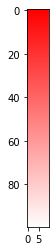

In [5]:
# -----------------------------------------
# 與如下功能一樣，r、g與b生成高為256寬為10的陣列，
# g、b像素縱軸由0至255，但橫軸不變；r像素皆為255
# -----------------------------------------

# r = np.outer(np.array([255]*256),np.ones(10)).astype(int)
# g = b = np.outer(np.arange(0,256,1),np.ones(10)).astype(int)


r = np.outer(np.array([1]*100),np.ones(10))
g = b = np.outer(np.arange(0,1,0.01),np.ones(10))

# RGB各別陣列來結合為三維度陣列
img = cv2.merge([r, g, b])

print(img.shape)
plt.imshow(img)                   
plt.show()

In [6]:
def bar_post(frame, x, y):
    
    # 以shape來獲取畫面的高與寬，並以高的三分之一作為bar的高，三十分之一則作為bar的寬
    h, w, channel = frame.shape
    bar_h = int(h/3)
    bar_w = int(h/(3*10))
    
    # 產生陣列r為255像素，其中高為256，寬為10; 產生陣列g, b為0由高漸增至255像素，其中高為256，寬為10
    r = np.outer(np.array([255]*256),np.ones(10))
    g = b = np.outer(np.arange(0,256,1),np.ones(10))
    
    # RGB陣列結合且轉為浮點數，並改為bar的寬與高
    img = cv2.merge([b, g, r]).astype(np.float32)
    img = cv2.resize(img,(bar_w, bar_h))
    
    # 將bar放入指定位置
    frame[y: y+bar_h, x: x+bar_w] = img
    
    cv2.putText(frame,"1",(x,int(y-0.5*bar_w)), font, h/700, (0,0,255), int(h/175))
    cv2.putText(frame,"0",(x,int(y+bar_h+1.5*bar_w)),font, h/700, (0,0,255), int(h/175))   
    
    return frame

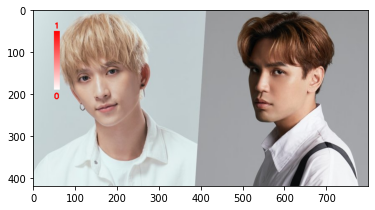

In [7]:
img = cv2.imread("Image_test/Face_test2.jpg")
img = cv2.resize(img, None, fx=1, fy=1)
img = bar_post(img,50,50)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
def bb_intersection_over_union(boxA, boxB):
    boxA = [int(x) for x in boxA]
    boxB = [int(x) for x in boxB]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [9]:
def face_post(frame, top_left, top_right, bottom_right, bottom_left, width, prediction, faces):
    
    if prediction =="angry":
        img = cv2.imread("Image_fer/00_Angry_Second.png")
    if prediction =="disgusted":
        img = cv2.imread("Image_fer/01_Disgust_Second.png")
    if prediction =="fearful":
        img = cv2.imread("Image_fer/02_Fear_Second.png")
    if prediction =="happy":
        img = cv2.imread("Image_fer/03_Happy_Second.png")
    if prediction =="sad":
        img = cv2.imread("Image_fer/04_Sad_Second.png")
    if prediction =="surprised":
        img = cv2.imread("Image_fer/05_Surprise_Second.png")
    if prediction =="neutral":
        img = cv2.imread("Image_fer/06_Neutral_Second.png")
    
    img_wh = int(width/2)
    img = cv2.resize(img, (img_wh,img_wh))
    
    IoU_rbr, IoU_rtr, IoU_lbl, IoU_ltl, IoU_rbb, IoU_lbb, IoU_rtt, IoU_ltt = [], [], [], [], [], [], [], []
    img_loc = []
    
    for (x, y, w, h) in faces:
        
        # 計算左上角與右下角
        
        # 人臉右下右半邊 （由於貼圖與人臉同X軸計算IOU會非零，故貼圖平移右一像素）
        img_top_left = (int(bottom_right[0]),int(bottom_right[1]-img_wh))
        img_bottom_right = (int(bottom_right[0]+img_wh),int(bottom_right[1]))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_rbr.append(bb_intersection_over_union([img_top_left[0]+1,img_top_left[1],img_bottom_right[0]+1,img_bottom_right[1]],[x, y, x+w, y+h]))
        
        # 人臉右上右半邊 （由於貼圖與人臉同X軸計算IOU會非零，故貼圖平移右一像素）# 新增
        img_top_left = (int(top_right[0]),int(top_right[1]))
        img_bottom_right = (int(top_right[0]+img_wh),int(top_right[1]+img_wh))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_rtr.append(bb_intersection_over_union([img_top_left[0]+1,img_top_left[1],img_bottom_right[0]+1,img_bottom_right[1]],[x, y, x+w, y+h]))
        
        # 人臉左下左半邊 （由於貼圖與人臉同X軸計算IOU會非零，故貼圖平移左一像素）# 新增
        img_top_left = (int(bottom_left[0]-img_wh),int(bottom_left[1]-img_wh))
        img_bottom_right = (int(bottom_left[0]),int(bottom_left[1]))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_lbl.append(bb_intersection_over_union([img_top_left[0]-1,img_top_left[1],img_bottom_right[0]-1,img_bottom_right[1]],[x, y, x+w, y+h]))
        
        # 人臉左上左半邊 （由於貼圖與人臉同X軸計算IOU會非零，故貼圖平移左一像素）
        img_top_left = (int(top_left[0]-img_wh),int(top_left[1]))
        img_bottom_right = (int(top_left[0]),int(top_left[1]+img_wh))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_ltl.append(bb_intersection_over_union([img_top_left[0]-1,img_top_left[1],img_bottom_right[0]-1,img_bottom_right[1]],[x, y, x+w, y+h]))
        
        # 人臉右下下半邊 （由於貼圖與人臉同Y軸計算IOU會非零，故貼圖平移下一像素）# 新增
        img_top_left = (int(bottom_right[0]-img_wh),int(bottom_right[1]))
        img_bottom_right = (int(bottom_right[0]),int(bottom_right[1]+img_wh))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_rbb.append(bb_intersection_over_union([img_top_left[0],img_top_left[1]+1,img_bottom_right[0],img_bottom_right[1]+1],[x, y, x+w, y+h]))
        
        # 人臉左下下半邊 （由於貼圖與人臉同Y軸計算IOU會非零，故貼圖平移下一像素）
        img_top_left = (int(bottom_left[0]),int(bottom_left[1]))
        img_bottom_right = (int(bottom_left[0]+img_wh),int(bottom_left[1]+img_wh))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_lbb.append(bb_intersection_over_union([img_top_left[0],img_top_left[1]+1,img_bottom_right[0],img_bottom_right[1]+1],[x, y, x+w, y+h]))
        
        # 人臉右上上半邊 （由於貼圖與人臉同Y軸計算IOU會非零，故貼圖平移上一像素）
        img_top_left = (int(top_right[0]-img_wh),int(top_right[1]-img_wh))
        img_bottom_right = (int(top_right[0]),int(top_right[1]))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_rtt.append(bb_intersection_over_union([img_top_left[0],img_top_left[1]-1,img_bottom_right[0],img_bottom_right[1]-1],[x, y, x+w, y+h]))
        
        # 人臉左上上半邊 （由於貼圖與人臉同Y軸計算IOU會非零，故貼圖平移上一像素）# 新增
        img_top_left = (int(top_left[0]),int(top_left[1]-img_wh))
        img_bottom_right = (int(top_left[0]+img_wh),int(top_left[1]))
        img_loc.append((img_top_left,img_bottom_right))
        IoU_ltt.append(bb_intersection_over_union([img_top_left[0],img_top_left[1]-1,img_bottom_right[0],img_bottom_right[1]-1],[x, y, x+w, y+h]))
        
        # 將左上與右下變數改為零，之後在IOU皆為零時會用到
        img_top_left = 0
        img_bottom_right = 0
        
    # 判斷貼圖與其他人臉的IOU是否為零，並針對四個角落，以及貼圖是否超過邊界之判斷
    Iou_total = [IoU_rbr, IoU_rtr, IoU_lbl, IoU_ltl, IoU_rbb, IoU_lbb, IoU_rtt, IoU_ltt]
    for i in range(len(Iou_total)):
        if np.all(np.array(Iou_total[i]) == 0):
            if img_loc[i][0][0]>0 and img_loc[i][0][1]>0 and img_loc[i][1][0]<frame.shape[1] and img_loc[i][1][1]<frame.shape[0]:
                img_top_left, img_bottom_right = img_loc[i]

    # 將左上與右下變數為非零時才貼圖，即上面非四個條件式都為Flase時才貼圖
    if img_top_left != 0 and img_bottom_right != 0:
        
        # 轉為灰階
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 二值化
        _, mask = cv2.threshold(img_gray, 25, 255, cv2.THRESH_BINARY_INV)
    
        area = frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh]
        area_no = cv2.bitwise_and(area,area,mask=mask)
        final = cv2.add(area_no, img)
        frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh] = final

    return frame

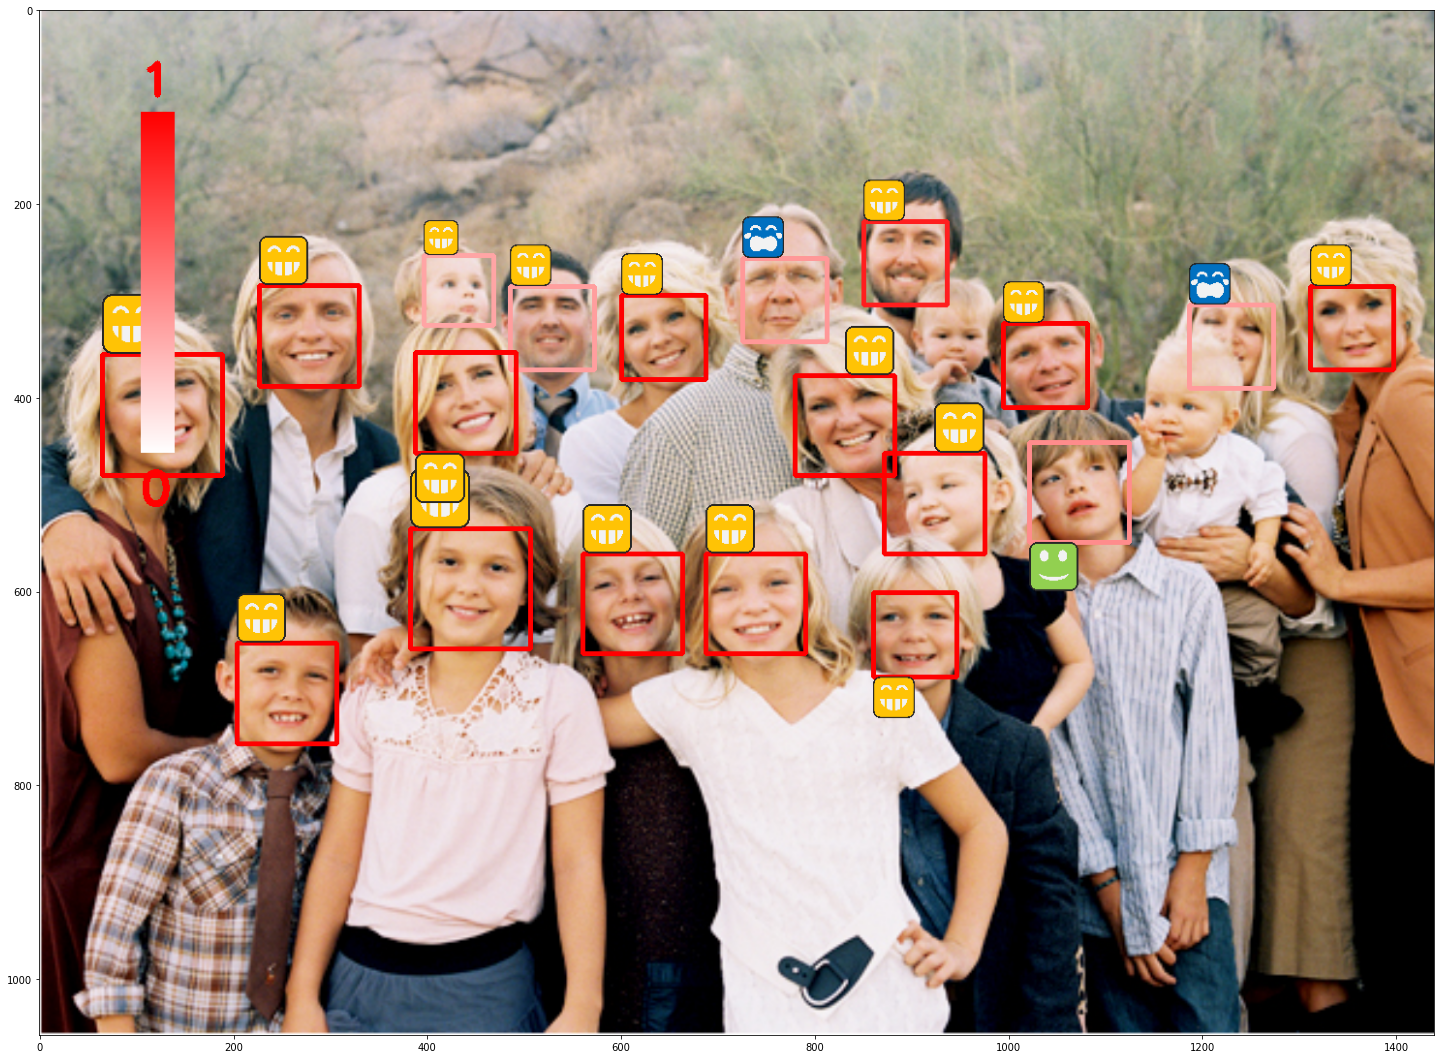

In [30]:
img = cv2.imread("Image_test/Face_test9.png")
img = cv2.resize(img, None, fx=2.4, fy=2.4)
data, frame = face_check(img, model)

cv2.imwrite("Face_test_fer.jpg",frame)

frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25,20))
plt.imshow(frame)
plt.show()

In [15]:
import cv2

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, img = VIDEO_IN.read()
    img = cv2.resize(img, None, fx=0.5, fy=0.5)
    data, img = face_check(img, model)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()

error: OpenCV(4.0.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3784: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
